In [2]:
import os
import requests
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

In [3]:
df = pd.read_csv("products_images.csv")

df.head()

,name,size,category,price,color,sku,description,images
0,New Look trench coat in camel,"UK 4,UK 6,UK 8,UK 10,UK 12,UK 14 - Out of stoc...",New Look trench coat in camel,49.99,neutral,126704571.0,[{'Product Details': 'Coats & Jackets by New L...,https://images.asos-media.com/products/new-loo...
1,Stradivarius double breasted wool coat in grey,"XS - UK 6,S - UK 8,M - UK 10,L - UK 12,XL - UK 14",Stradivarius double breasted wool coat in grey,59.99,grey,123650194.0,[{'Product Details': 'Coats & Jackets by Strad...,https://images.asos-media.com/products/stradiv...
2,JDY oversized trench coat in stone,"3XL - UK 18 - Out of stock,XS - UK 6,S - UK 8,...",JDY oversized trench coat in stone,45.00,stone,125806824.0,[{'Product Details': 'Coats & Jackets by JDYLo...,https://images.asos-media.com/products/jdy-ove...
3,Nike Running hooded jacket in pink,"XS - UK 4-6,S - UK 8-10,M - UK 12-14,L - UK 16...",Nike Running hooded jacket in pink,84.95,pink,121963507.0,[{'Product Details': 'Coats & Jackets by Nike ...,https://images.asos-media.com/products/nike-ru...
4,ASOS DESIGN Tall linen mix trench coat in natural,"UK 4,UK 6,UK 8,UK 10,UK 12,UK 14,UK 16,UK 18,U...",ASOS DESIGN Tall linen mix trench coat in natural,75.00,natural,123053365.0,[{'Product Details': 'Coats & Jackets by ASOS ...,https://images.asos-media.com/products/asos-de...


In [3]:
df = pd.read_csv("asos_final_clean.csv")

df.head()

,price,sku,description,images,brand,item_category,main_material,fit_type,color_simple
0,49.99,126704571,Coats & Jackets by New Look Low-key layering N...,https://images.asos-media.com/products/new-loo...,New Look,Coats & Jackets,Polyester,Regular,Beige
1,59.99,123650194,Coats & Jackets by Stradivarius Jacket upgrade...,https://images.asos-media.com/products/stradiv...,Stradivarius,Coats & Jackets,Polyester,Regular,Grey
2,45.00,125806824,Coats & Jackets by JDY Low-key layering Notch ...,https://images.asos-media.com/products/jdy-ove...,JDY,Coats & Jackets,Polyester,Oversized,Beige
3,84.95,121963507,Coats & Jackets by Nike Running Hit that new P...,https://images.asos-media.com/products/nike-ru...,Nike Running,Coats & Jackets,Polyester,Regular,Black
4,75.00,123053365,Coats & Jackets by ASOS Tall Throw-on appeal N...,https://images.asos-media.com/products/asos-de...,ASOS Tall,Coats & Jackets,Cotton,Regular,Beige


In [4]:
from curl_cffi import requests # <--- Note the import change
import pandas as pd
import os

# 1. Pick a URL from your actual data
test_url = df['images'].iloc[0].strip("[]'\" ") 
print(f"Testing URL: {test_url}")

# 2. Try Download with 'impersonate'
# We don't need manual headers; 'impersonate' generates the correct ones automatically
print("Attempting download with Chrome impersonation...")

try:
    response = requests.get(
        test_url, 
        impersonate="chrome", # The magic parameter that bypasses the block
        timeout=10
    )
    
    print(f"Status Code: {response.status_code}")
    
    if response.status_code == 200:
        with open("test_cffi.jpg", "wb") as f:
            f.write(response.content)
        print("Success! Saved 'test_cffi.jpg'. Check your folder to verify it opens.")
    else:
        print(f"Failed. Response content: {response.text[:100]}")

except Exception as e:
    print(f"Error: {e}")

Testing URL: https://images.asos-media.com/products/new-look-trench-coat-in-camel/204351106-4?$n_1920w$&wid=1926&fit=constrain
Attempting download with Chrome impersonation...
Status Code: 200
Success! Saved 'test_cffi.jpg'. Check your folder to verify it opens.


In [5]:
import os
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from curl_cffi import requests # The library that impersonates Chrome

# --- CONFIGURATION ---
RAW_DIR = 'asos_images_raw'
MAX_WORKERS = 25  # 25 is the sweet spot for curl_cffi stability
TIMEOUT = 15      # Seconds to wait for a server response

os.makedirs(RAW_DIR, exist_ok=True)

# --- LOAD DATA ---
# Ensure df is loaded and clean
if 'df' not in locals():
    df = pd.read_csv('products_images.csv')

# Filter for valid rows only
df_download = df.dropna(subset=['sku']).copy()
df_download['sku'] = df_download['sku'].astype(int).astype(str)

print(f"Queueing {len(df_download)} images for download...")

# --- THE WORKER FUNCTION ---
def download_safe(row):
    try:
        sku = row['sku']
        # 1. Clean URL
        url = str(row['images']).strip("[]'\" ")
        
        # Basic validation
        if not url.startswith('http'): 
            return "skipped_bad_url"
        
        save_path = os.path.join(RAW_DIR, f"{sku}.jpg")
        
        # 2. Check if already exists (resume capability)
        if os.path.exists(save_path):
            # Optional: Check if it's not a 0kb empty file
            if os.path.getsize(save_path) > 0:
                return "skipped_exists"

        # 3. Impersonate Chrome
        # We use a fresh request per thread to avoid session threading issues with cffi
        response = requests.get(
            url, 
            impersonate="chrome", 
            timeout=TIMEOUT
        )
        
        # 4. Save
        if response.status_code == 200:
            with open(save_path, 'wb') as f:
                f.write(response.content)
            return "success"
        
        elif response.status_code == 404:
            return "error_404_not_found"
        else:
            return f"error_{response.status_code}"

    except Exception as e:
        # Catch network timeouts or library errors
        return "error_exception"

# --- EXECUTION ---
rows = df_download.to_dict('records')
results = []

print(f"Starting download to '{RAW_DIR}' with {MAX_WORKERS} workers.")
print("This may take 15-30 minutes...")

with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    # Submit all tasks
    futures = [executor.submit(download_safe, row) for row in rows]
    
    # Track progress
    pbar = tqdm(as_completed(futures), total=len(rows), unit="img")
    
    for future in pbar:
        res = future.result()
        results.append(res)
        
        # Update progress bar description with latest status occasionally
        if len(results) % 50 == 0:
            pbar.set_description(f"Status: {res}")

# --- FINAL REPORT ---
from collections import Counter
counts = Counter(results)

print("\n--- Download Summary ---")
for status, count in counts.items():
    print(f"{status}: {count}")

print(f"\nImages saved to: {os.path.abspath(RAW_DIR)}")

Queueing 29971 images for download...
Starting download to 'asos_images_raw' with 25 workers.
This may take 15-30 minutes...


Status: success: 100%|██████████| 29971/29971 [12:22<00:00, 40.39img/s]  


--- Download Summary ---
success: 29971

Images saved to: /home/grom/DevFiles/Classes/MIS382N/FinalProject/asos_images_raw


In [3]:
# Convert 12345.0 (float) -> 12345 (int) -> "12345" (string)
df['sku'] = df['sku'].fillna(0).astype(int).astype(str)

# Verify
print(f"Sample SKU: {df['sku'].iloc[0]}") # Should print "12345", not "12345.0"

Sample SKU: 126704571


In [4]:
i = 120

print(df['name'].iloc[i])
print(df['sku'].iloc[i])
df['images'].iloc[i]

Topshop mid length tie belted puffer jacket in forest green
117868482


'https://images.asos-media.com/products/topshop-mid-length-tie-belted-puffer-jacket-in-forest-green/202710620-4?$n_1920w$&wid=1926&fit=constrain'

In [24]:
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm # Progress bar

# 1. Setup paths
img_folder = "asos_images_raw"
original_csv = "products_images.csv" # Your current dataframe file
output_csv = "asos_cleaned.csv"

# 2. Load Data
print(f"Original Row Count: {len(df)}")

valid_rows = []

# 3. Iterate and Verify
# We check if the file exists AND if it can be opened by PIL
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    sku = str(row['sku']) # Ensure string format
    img_path = os.path.join(img_folder, f"{sku}.jpg")
    
    if os.path.exists(img_path):
        try:
            # Try opening to check for corruption
            with Image.open(img_path) as img:
                img.verify() # fast check
            valid_rows.append(row)
        except Exception as e:
            print(f"Corrupt image found: {sku}.jpg - {e}")
    else:
        # Image in CSV but not in folder
        pass 

# 4. Save the "Clean" Metadata
df_clean = pd.DataFrame(valid_rows)
df_clean.to_csv(output_csv, index=False)
print(f"Cleaned Row Count: {len(df_clean)}")
print(f"Removed {len(df) - len(df_clean)} rows due to missing/bad images.")

Original Row Count: 29971


100%|██████████| 29971/29971 [00:02<00:00, 12825.38it/s]


Cleaned Row Count: 29971
Removed 0 rows due to missing/bad images.


In [4]:
from sklearn.model_selection import train_test_split

# Load the clean data
df = pd.read_csv("asos_final_clean.csv")

# Perform 90/10 split
train_df, test_df = train_test_split(df, test_size=0.10, random_state=42)

# Save them separately
train_df.to_csv("train.csv", index=False)
test_df.to_csv("test.csv", index=False)

print(f"Training Samples: {len(train_df)}")
print(f"Testing Samples: {len(test_df)}")

Training Samples: 26973
Testing Samples: 2998


In [ ]:
from torchvision import transforms

# Training transforms (includes data augmentation to reduce overfitting)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # Resize to ConvNeXt standard
    transforms.RandomHorizontalFlip(), # Augmentation (optional but recommended)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Validation/Test transforms (NO augmentation, just resize & normalize)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

In [28]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# 1. Define the Dataset Class (The Bridge)
class ASOSPriceDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.metadata = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        # Get the row
        row = self.metadata.iloc[idx]
        
        # Get SKU and build image path
        sku = str(int(row['sku'])) # Ensure it matches your filename format
        img_name = os.path.join(self.img_dir, f"{sku}.jpg")

        # Load Image
        image = Image.open(img_name).convert('RGB')
        
        # Apply the transforms (Resize -> Tensor -> Normalize) you defined earlier
        if self.transform:
            image = self.transform(image)
        
        # Get Price (Target)
        # NOTE: Ensure your CSV has a column named 'price'
        price = float(row['price']) 
        price_tensor = torch.tensor(price, dtype=torch.float32)

        return image, price_tensor

# 2. Instantiate the Datasets
# We use the transforms you defined in your previous step
train_dataset = ASOSPriceDataset(
    csv_file='train.csv', 
    img_dir='asos_images_raw', 
    transform=train_transforms 
)

test_dataset = ASOSPriceDataset(
    csv_file='test.csv', 
    img_dir='asos_images_raw', 
    transform=val_transforms
)

# 3. Create the Loaders
# Batch size 32 is standard. Lower to 16 if you get "CUDA Out of Memory".
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Ready to train on {len(train_dataset)} images.")

Ready to train on 26973 images.


In [4]:
df = pd.read_csv("asos_cleaned.csv")

df.head()

,name,size,category,price,color,sku,description,images
0,New Look trench coat in camel,"UK 4,UK 6,UK 8,UK 10,UK 12,UK 14 - Out of stoc...",New Look trench coat in camel,49.99,neutral,126704571,[{'Product Details': 'Coats & Jackets by New L...,https://images.asos-media.com/products/new-loo...
1,Stradivarius double breasted wool coat in grey,"XS - UK 6,S - UK 8,M - UK 10,L - UK 12,XL - UK 14",Stradivarius double breasted wool coat in grey,59.99,grey,123650194,[{'Product Details': 'Coats & Jackets by Strad...,https://images.asos-media.com/products/stradiv...
2,JDY oversized trench coat in stone,"3XL - UK 18 - Out of stock,XS - UK 6,S - UK 8,...",JDY oversized trench coat in stone,45.00,stone,125806824,[{'Product Details': 'Coats & Jackets by JDYLo...,https://images.asos-media.com/products/jdy-ove...
3,Nike Running hooded jacket in pink,"XS - UK 4-6,S - UK 8-10,M - UK 12-14,L - UK 16...",Nike Running hooded jacket in pink,84.95,pink,121963507,[{'Product Details': 'Coats & Jackets by Nike ...,https://images.asos-media.com/products/nike-ru...
4,ASOS DESIGN Tall linen mix trench coat in natural,"UK 4,UK 6,UK 8,UK 10,UK 12,UK 14,UK 16,UK 18,U...",ASOS DESIGN Tall linen mix trench coat in natural,75.00,natural,123053365,[{'Product Details': 'Coats & Jackets by ASOS ...,https://images.asos-media.com/products/asos-de...


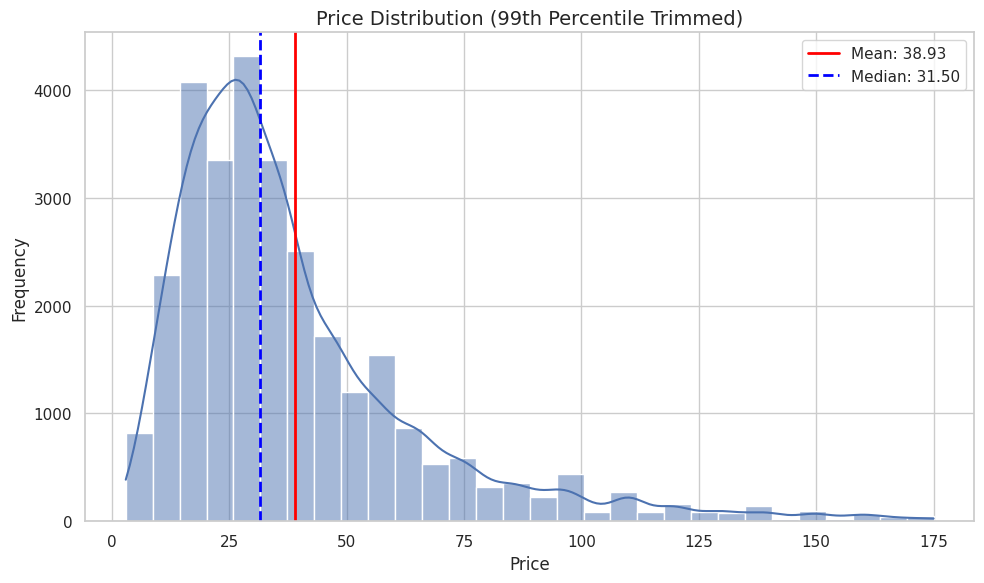

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Trim at the 99th percentile
cutoff = df["price"].quantile(0.99)
df_trim = df[df["price"] <= cutoff]

mean_val = df_trim["price"].mean()
median_val = df_trim["price"].median()

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(
    df_trim["price"],
    bins=30,
    kde=True,
    stat="count"
)

# Mean and median lines
plt.axvline(mean_val, color="red", linewidth=2, label=f"Mean: {mean_val:.2f}")
plt.axvline(median_val, color="blue", linewidth=2, linestyle="--", label=f"Median: {median_val:.2f}")

plt.xlabel("Price", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Price Distribution (99th Percentile Trimmed)", fontsize=14)

plt.legend()

plt.tight_layout()

plt.savefig("price_distribution_trimmed.png", dpi=300)
plt.show()


In [14]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 99th-percentile trimming (same as plot)
cutoff = df["price"].quantile(0.99)
y = df.loc[df["price"] <= cutoff, "price"].values.astype(float)

# mean baseline
mean_val = y.mean()
y_pred_mean = np.full(y.shape, mean_val)
mse_mean = mean_squared_error(y, y_pred_mean)
rmse_mean = np.sqrt(mse_mean)
r2_mean = r2_score(y, y_pred_mean)
mae_mean = mean_absolute_error(y, y_pred_mean)

# median baseline
median_val = np.median(y)
y_pred_median = np.full(y.shape, median_val)
mse_median = mean_squared_error(y, y_pred_median)
rmse_median = np.sqrt(mse_median)
r2_median = r2_score(y, y_pred_median)
mae_median = mean_absolute_error(y, y_pred_median)

# pretty table for slides
table = pd.DataFrame({
    "Baseline": ["Mean", "Median"],
    "Prediction Value": [mean_val, median_val],
    "RMSE": [rmse_mean, rmse_median],
    "R²": [r2_mean, r2_median],
    "MAE": [mae_mean, mae_median]
}).round(4)

table


,Baseline,Prediction Value,RMSE,R²,MAE
0,Mean,38.9321,27.1498,0.0000,19.5291
1,Median,31.5000,28.1486,-0.0749,18.4125
